In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from scipy.spatial import distance
import math
from sklearn.metrics import mean_absolute_error

# Instructions:
### To Evaluate Data recorded with Walker using 3 localization algorithms. Compare the position x, y, and orientation.

# Ideal Set:

In [2]:
ideal = pd.read_csv("data/base.csv")
ideal = ideal.drop('Unnamed: 0', 1)
ideal.head(10)

,time,pos-x,pos-y,pos-z,ori-x,ori-y,ori-z,ori-w
0,2018-04-21 17:02:06.437315,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2018-04-21 17:02:06.635024,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2018-04-21 17:02:06.830227,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2018-04-21 17:02:07.039201,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2018-04-21 17:02:07.239482,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,2018-04-21 17:02:07.448714,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,2018-04-21 17:02:07.661616,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,2018-04-21 17:02:07.870263,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,2018-04-21 17:02:08.073864,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,2018-04-21 17:02:08.279981,0.0,0.0,0.0,0.0,0.0,0.0,1.0


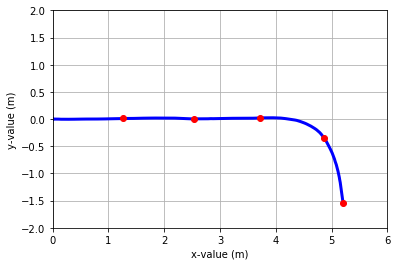

In [3]:
plt.plot(ideal['pos-x'], ideal['pos-y'], c='b', label='ideal',linewidth=3.0)
plt.axis([0, 6, -2, 2])
plt.grid(True)
plt.xlabel("x-value (m)")
plt.ylabel("y-value (m)")
plt.plot(1.25447706098, 0.0115443692726, 'ro')
plt.plot(2.53141807085, 0.00401534871211, 'ro')
plt.plot(3.71243980664, 0.0209999922646, 'ro')
plt.plot(4.86053443033, -0.33993103047, 'ro')
plt.plot(5.20222973989, -1.54787330945, 'ro')
plt.show()

# Loading and Preprocessing:
### Dropping columns, adding new columns with the error, and distance travelled

In [4]:
def euclid(start, end):
    dist = round(distance.euclidean(start,end),2)
    return dist

# calculate the euclidian distance traveled
def distance_traveled(df):
    df['distance'] = np.nan
    df['distance'].loc[0] = round(euclid((0,0),(df["pos-x"].loc[0], df["pos-y"].loc[0])),2)
    for i in range(1,len(df)):
        value = euclid((df["pos-x"].loc[i-1], df["pos-y"].loc[i-1]), (df["pos-x"].loc[i], df["pos-y"].loc[i]))
        value = round(value,2)
        df['distance'].loc[i] = df['distance'].loc[i-1] + value
    return df['distance']

# drop values that have repeted distance values
def uniqness_distanced_based(df):
    df = df.drop_duplicates(['distance'])
    return df

# to remove the zeros at start
def zero_remover(df):
    try:
        df = df.drop('Unnamed: 0', 1)
    except:
        print("No Unnamed Column")
    df = df.drop('time', 1)
    df = df.drop('pos-z', 1)
    df = df.drop('ori-x', 1)
    df = df.drop('ori-y', 1)
    vals = []
    for i in range(1, len(df)):
        if((df['pos-x'].iloc[i] == 0) and (df['pos-y'].iloc[i]) == 0):
            vals.append(i)
    df = df.drop(df.index[[vals]])
    return df
    
# to re index data with time intervals of 205 ms
def indexing(df):
    step = 205
    df['time'] = np.nan
    for i in range(0, len(df)):
        df['time'].iloc[i] = step
        step = step + 205
    return df

# to make sure each set has same number of elements
def sampling(df, largest_df):
    to_append = df.tail(1)[['pos-x', 'pos-y', 'ori-z', 'ori-w']].to_dict(orient='records')[0]
    rows_to_append = len(largest_df) - len(df)
    for _ in range(rows_to_append):
        df = df.append(to_append, ignore_index=True)
    return df
    
def error(ideal, df, column_name):
    df['diff-' + str(column_name)] = ideal[column_name] - df[column_name]
    return df

def all_errors(df):
    df = error(ideal, df, 'pos-x')
    df = error(ideal, df, 'pos-y')
    df = error(ideal, df, 'ori-z')
    df = error(ideal, df, 'ori-w')
    return df

def preproces(ideal, df):
    #remove the zeros in the beginning except first row
    df = zero_remover(df)
    
    #reseting the index
    df = df.reset_index(drop=True)
    
    # sampling the data
    #df = sampling(df, ideal)
    
    # indexing the data by autoincrementing by 205
    df = indexing(df)
    
    #calculating the traveled distance
    df['distance'] = distance_traveled(df)
    
    #cleaning the data based on the traveled distance
    #df = uniqness_distanced_based(df)
    
    return df

## AMCL Data

In [5]:
ideal = pd.read_csv("data/base.csv")
ideal = preproces(ideal, ideal)
ideal = all_errors(ideal)

amcl1 = pd.read_csv("data/amcl/amcl_1.csv")
amcl1 = preproces(ideal, amcl1)
amcl1 = all_errors(amcl1)

amcl2 = pd.read_csv("data/amcl/amcl_2.csv")
amcl2 = preproces(ideal, amcl2)
amcl2 = all_errors(amcl2)

amcl3 = pd.read_csv("data/amcl/amcl_3.csv")
amcl3 = preproces(ideal, amcl3)
amcl3 = all_errors(amcl3)

amcl4 = pd.read_csv("data/amcl/amcl_4.csv")
amcl4 = preproces(ideal, amcl4)
amcl4 = all_errors(amcl4)

amcl5 = pd.read_csv("data/amcl/amcl_5.csv")
amcl5 = preproces(ideal, amcl5)
amcl5 = all_errors(amcl5)

amcl6 = pd.read_csv("data/amcl/amcl_6.csv")
amcl6 = preproces(ideal, amcl6)
amcl6 = all_errors(amcl6)

amcl7 = pd.read_csv("data/amcl/amcl_7.csv")
amcl7 = preproces(ideal, amcl7)
amcl7 = all_errors(amcl7)

amcl8 = pd.read_csv("data/amcl/amcl_8.csv")
amcl8 = preproces(ideal, amcl8)
amcl8 = all_errors(amcl8)

amcl9 = pd.read_csv("data/amcl/amcl_9.csv")
amcl9 = preproces(ideal, amcl9)
amcl9 = all_errors(amcl9)

amcl10 = pd.read_csv("data/amcl/amcl_10.csv")
amcl10 = preproces(ideal, amcl10)
amcl10 = all_errors(amcl10)

In [6]:
# sample
print("Overview of the processed dataset")
print(amcl1.head(3))

Overview of the processed dataset
      pos-x     pos-y     ori-z     ori-w   time  distance  diff-pos-x  \
0 -0.002826  0.000035  0.006171  0.999981  205.0       0.0    0.002826   
1 -0.002826  0.000035  0.006171  0.999981  410.0       0.0    0.000000   
2 -0.002826  0.000035  0.006171  0.999981  615.0       0.0    0.005642   

   diff-pos-y  diff-ori-z  diff-ori-w  
0   -0.000035   -0.006171    0.000019  
1   -0.000070   -0.012343    0.000000  
2   -0.000418    0.012342   -0.000152  


# CDF of the ratio between the length of the path traversed by the robot to that of the optimal path

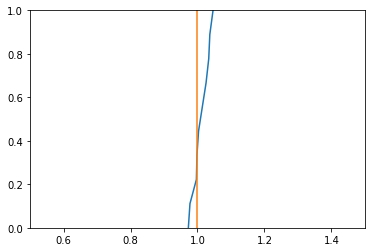

In [7]:
%matplotlib inline
New_list = []
var = (amcl1[['distance']].tail(1).iloc[0, 0])
New_list.append(var)

var = (amcl2[['distance']].tail(1).iloc[0, 0])
New_list.append(var)

var = (amcl3[['distance']].tail(1).iloc[0, 0])
New_list.append(var)

var = (amcl4[['distance']].tail(1).iloc[0, 0])
New_list.append(var)

var = (amcl5[['distance']].tail(1).iloc[0, 0])
New_list.append(var)

var = (amcl6[['distance']].tail(1).iloc[0, 0])
New_list.append(var)

var = (amcl7[['distance']].tail(1).iloc[0, 0])
New_list.append(var)

var = (amcl8[['distance']].tail(1).iloc[0, 0])
New_list.append(var)

var = (amcl9[['distance']].tail(1).iloc[0, 0])
New_list.append(var)

var = (amcl10[['distance']].tail(1).iloc[0, 0])
New_list.append(var)

New_list = New_list/(ideal[['distance']].tail(1).iloc[0, 0])

amcl_sorted_data = np.sort(New_list)

amcl_yvals=np.arange(len(amcl_sorted_data))/float(len(amcl_sorted_data)-1)

ideal_data = [6.24, 6.24, 6.24, 6.24, 6.24, 6.24, 6.24, 6.24, 6.24, 6.24]
ideal_data = ideal_data/(ideal[['distance']].tail(1).iloc[0, 0])
ideal_yvals=np.arange(len(ideal_data))/float(len(ideal_data)-1)

plt.plot(amcl_sorted_data,amcl_yvals)
plt.plot(ideal_data,ideal_yvals)

plt.axis([0.5, 1.5, 0, 1])
plt.show()

# Average Distance taken Error for AMCL:

In [8]:
def average_error_distance(df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, ideal):
    var = (df1[['distance']].tail(1).iloc[0, 0])
    var2 = (df2[['distance']].tail(1).iloc[0, 0])
    var3 = (df3[['distance']].tail(1).iloc[0, 0])
    var4 = (df4[['distance']].tail(1).iloc[0, 0])
    var5 = (df5[['distance']].tail(1).iloc[0, 0])
    var6 = (df6[['distance']].tail(1).iloc[0, 0])
    var7 = (df7[['distance']].tail(1).iloc[0, 0])
    var8 = (df8[['distance']].tail(1).iloc[0, 0])
    var9 = (df9[['distance']].tail(1).iloc[0, 0])
    var10 = (df10[['distance']].tail(1).iloc[0, 0])
    average_var = (var + var2 + var3 + var4 + var5 + var6 + var7 + var8 + var9 + var10)/10
    ideal_var = (ideal[['distance']].tail(1).iloc[0, 0])
    average_error_var = abs(ideal_var - average_var)
    return average_error_var


# Performing CDF of the position in AMCL

In [9]:
 def the_index_to_check(df):
    n_bins = 5
    vars_list = []
    end = df[['distance']].tail(1).iloc[0, 0]
    end = round(end,2)
    start = round((end/n_bins),2)
    var = start
    for i in range(0, n_bins-1):
        new = check_the_val(df, var)
        var = var + start
        vars_list.append(new)
    vars_list.append(end)
    return vars_list

def check_the_val(df, distance_index):
    var = 0
    distance_index = round(distance_index, 2)
    for i in range(0, len(df)):
        if((df['distance'].iloc[i] > distance_index-0.05) and (df['distance'].iloc[i] < distance_index+0.05)):
            var = df['pos-x'].iloc[i]
            pass
    return var

def table_maker(ideal, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10):
    cdf_list_ideal = the_index_to_check(ideal)
    cdf_list_1 = the_index_to_check(df1)
    cdf_list_2 = the_index_to_check(df2)
    cdf_list_3 = the_index_to_check(df3)
    cdf_list_4 = the_index_to_check(df4)
    cdf_list_5 = the_index_to_check(df5)
    cdf_list_6 = the_index_to_check(df6)
    cdf_list_7 = the_index_to_check(df7)
    cdf_list_8 = the_index_to_check(df8)
    cdf_list_9 = the_index_to_check(df9)
    cdf_list_10 = the_index_to_check(df10)
    
    final_list_1 = []
    final_list_2 = []
    final_list_3 = []
    final_list_4 = []
    final_list_5 = []
    
    final_list_1.append(abs((cdf_list_ideal[0]) - (cdf_list_1[0])))
    final_list_1.append(abs((cdf_list_ideal[0]) - (cdf_list_2[0])))
    final_list_1.append(abs((cdf_list_ideal[0]) - (cdf_list_3[0])))
    final_list_1.append(abs((cdf_list_ideal[0]) - (cdf_list_4[0])))
    final_list_1.append(abs((cdf_list_ideal[0]) - (cdf_list_5[0])))
    final_list_1.append(abs((cdf_list_ideal[0]) - (cdf_list_6[0])))
    final_list_1.append(abs((cdf_list_ideal[0]) - (cdf_list_7[0])))
    final_list_1.append(abs((cdf_list_ideal[0]) - (cdf_list_8[0])))
    final_list_1.append(abs((cdf_list_ideal[0]) - (cdf_list_9[0])))
    final_list_1.append(abs((cdf_list_ideal[0]) - (cdf_list_10[0])))
    
    final_list_2.append(abs((cdf_list_ideal[1]) - (cdf_list_1[1])))
    final_list_2.append(abs((cdf_list_ideal[1]) - (cdf_list_2[1])))
    final_list_2.append(abs((cdf_list_ideal[1]) - (cdf_list_3[1])))
    final_list_2.append(abs((cdf_list_ideal[1]) - (cdf_list_4[1])))
    final_list_2.append(abs((cdf_list_ideal[1]) - (cdf_list_5[1])))
    final_list_2.append(abs((cdf_list_ideal[1]) - (cdf_list_6[1])))
    final_list_2.append(abs((cdf_list_ideal[1]) - (cdf_list_7[1])))
    final_list_2.append(abs((cdf_list_ideal[1]) - (cdf_list_8[1])))
    final_list_2.append(abs((cdf_list_ideal[1]) - (cdf_list_9[1])))
    final_list_2.append(abs((cdf_list_ideal[1]) - (cdf_list_10[1])))
    
    final_list_3.append(abs((cdf_list_ideal[2]) - (cdf_list_1[2])))
    final_list_3.append(abs((cdf_list_ideal[2]) - (cdf_list_2[2])))
    final_list_3.append(abs((cdf_list_ideal[2]) - (cdf_list_3[2])))
    final_list_3.append(abs((cdf_list_ideal[2]) - (cdf_list_4[2])))
    final_list_3.append(abs((cdf_list_ideal[2]) - (cdf_list_5[2])))
    final_list_3.append(abs((cdf_list_ideal[2]) - (cdf_list_6[2])))
    final_list_3.append(abs((cdf_list_ideal[2]) - (cdf_list_7[2])))
    final_list_3.append(abs((cdf_list_ideal[2]) - (cdf_list_8[2])))
    final_list_3.append(abs((cdf_list_ideal[2]) - (cdf_list_9[2])))
    final_list_3.append(abs((cdf_list_ideal[2]) - (cdf_list_10[2])))
    
    final_list_4.append(abs((cdf_list_ideal[3]) - (cdf_list_1[3])))
    final_list_4.append(abs((cdf_list_ideal[3]) - (cdf_list_2[3])))
    final_list_4.append(abs((cdf_list_ideal[3]) - (cdf_list_3[3])))
    final_list_4.append(abs((cdf_list_ideal[3]) - (cdf_list_4[3])))
    final_list_4.append(abs((cdf_list_ideal[3]) - (cdf_list_5[3])))
    final_list_4.append(abs((cdf_list_ideal[3]) - (cdf_list_6[3])))
    final_list_4.append(abs((cdf_list_ideal[3]) - (cdf_list_7[3])))
    final_list_4.append(abs((cdf_list_ideal[3]) - (cdf_list_8[3])))
    final_list_4.append(abs((cdf_list_ideal[3]) - (cdf_list_9[3])))
    final_list_4.append(abs((cdf_list_ideal[3]) - (cdf_list_10[3])))
    
    final_list_5.append(abs((cdf_list_ideal[4]) - (cdf_list_1[4])))
    final_list_5.append(abs((cdf_list_ideal[4]) - (cdf_list_2[4])))
    final_list_5.append(abs((cdf_list_ideal[4]) - (cdf_list_3[4])))
    final_list_5.append(abs((cdf_list_ideal[4]) - (cdf_list_4[4])))
    final_list_5.append(abs((cdf_list_ideal[4]) - (cdf_list_5[4])))
    final_list_5.append(abs((cdf_list_ideal[4]) - (cdf_list_6[4])))
    final_list_5.append(abs((cdf_list_ideal[4]) - (cdf_list_7[4])))
    final_list_5.append(abs((cdf_list_ideal[4]) - (cdf_list_8[4])))
    final_list_5.append(abs((cdf_list_ideal[4]) - (cdf_list_9[4])))
    final_list_5.append(abs((cdf_list_ideal[4]) - (cdf_list_10[4])))
    
    
    
    return final_list_1, final_list_2, final_list_3, final_list_4, final_list_5

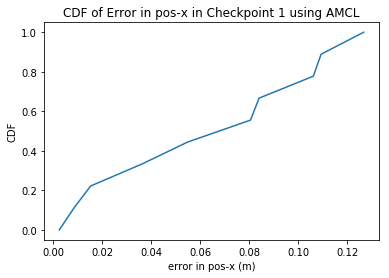

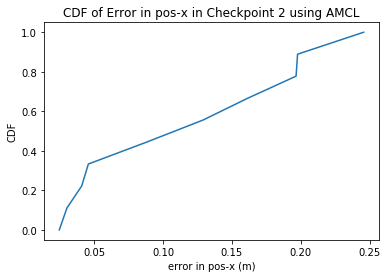

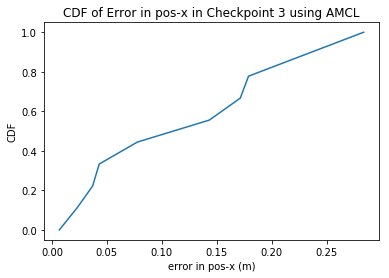

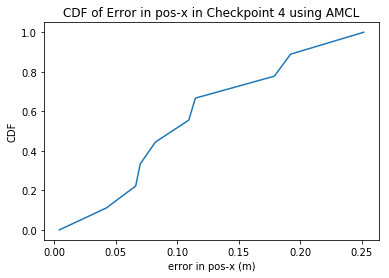

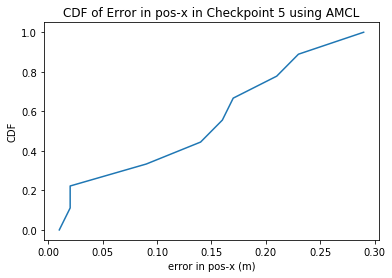

In [10]:
cdf_amcl_points1, cdf_amcl_points2, cdf_amcl_points3, cdf_amcl_points4, cdf_amcl_points5  = table_maker(ideal, amcl1, amcl2, amcl3, amcl4, amcl5, amcl6, amcl7, amcl8, amcl9, amcl10)
#plotting CDF of Error in POS-X AMCL Check-Point 1
cdf_amcl_points1 = np.sort(cdf_amcl_points1)
cdf_amcl_points1_yvals=np.arange(len(cdf_amcl_points1))/float(len(cdf_amcl_points1)-1)
plt.plot(cdf_amcl_points1,cdf_amcl_points1_yvals)
plt.ylabel("CDF")
plt.xlabel("error in pos-x (m)")
plt.title("CDF of Error in pos-x in Checkpoint 1 using AMCL")
plt.show()

#plotting CDF of Error in POS-X AMCL Check-Point 2
cdf_amcl_points2 = np.sort(cdf_amcl_points2)
cdf_amcl_points2_yvals=np.arange(len(cdf_amcl_points2))/float(len(cdf_amcl_points2)-1)
plt.plot(cdf_amcl_points2,cdf_amcl_points2_yvals)
plt.ylabel("CDF")
plt.xlabel("error in pos-x (m)")
plt.title("CDF of Error in pos-x in Checkpoint 2 using AMCL")
plt.show()

#plotting CDF of Error in POS-X AMCL Check-Point 3
cdf_amcl_points3 = np.sort(cdf_amcl_points3)
cdf_amcl_points3_yvals=np.arange(len(cdf_amcl_points3))/float(len(cdf_amcl_points3)-1)
plt.plot(cdf_amcl_points3,cdf_amcl_points3_yvals)
plt.ylabel("CDF")
plt.xlabel("error in pos-x (m)")
plt.title("CDF of Error in pos-x in Checkpoint 3 using AMCL")
plt.show()

#plotting CDF of Error in POS-X AMCL Check-Point 4
cdf_amcl_points4 = np.sort(cdf_amcl_points4)
cdf_amcl_points4_yvals=np.arange(len(cdf_amcl_points4))/float(len(cdf_amcl_points4)-1)
plt.plot(cdf_amcl_points4,cdf_amcl_points4_yvals)
plt.ylabel("CDF")
plt.xlabel("error in pos-x (m)")
plt.title("CDF of Error in pos-x in Checkpoint 4 using AMCL")
plt.show()

#plotting CDF of Error in POS-X AMCL Check-Point 
cdf_amcl_points5 = np.sort(cdf_amcl_points5)
cdf_amcl_points5_yvals=np.arange(len(cdf_amcl_points5))/float(len(cdf_amcl_points5)-1)
plt.plot(cdf_amcl_points5,cdf_amcl_points5_yvals)
plt.ylabel("CDF")
plt.xlabel("error in pos-x (m)")
plt.title("CDF of Error in pos-x in Checkpoint 5 using AMCL")
plt.show()


extra = the_index_to_check(ideal)


# Gmapping Data

In [11]:
gmap1 = pd.read_csv("data/gmapping/gmap_1.csv")
gmap1 = preproces(ideal, gmap1)
gmap1 = all_errors(gmap1)

gmap2 = pd.read_csv("data/gmapping/gmap_2.csv")
gmap2 = preproces(ideal, gmap2)
gmap2 = all_errors(gmap2)

gmap3 = pd.read_csv("data/gmapping/gmap_3.csv")
gmap3 = preproces(ideal, gmap3)
gmap3 = all_errors(gmap3)

gmap4 = pd.read_csv("data/gmapping/gmap_4.csv")
gmap4 = preproces(ideal, gmap4)
gmap4 = all_errors(gmap4)

gmap5 = pd.read_csv("data/gmapping/gmap_5.csv")
gmap5 = preproces(ideal, gmap5)
gmap5 = all_errors(gmap5)

gmap6 = pd.read_csv("data/gmapping/gmap_6.csv")
gmap6 = preproces(ideal, gmap6)
gmap6 = all_errors(gmap6)

gmap7 = pd.read_csv("data/gmapping/gmap_7.csv")
gmap7 = preproces(ideal, gmap7)
gmap7 = all_errors(gmap7)

gmap8 = pd.read_csv("data/gmapping/gmap_8.csv")
gmap8 = preproces(ideal, gmap8)
gmap8 = all_errors(gmap8)

gmap9 = pd.read_csv("data/gmapping/gmap_9.csv")
gmap9 = preproces(ideal, gmap9)
gmap9 = all_errors(gmap9)

gmap10 = pd.read_csv("data/gmapping/gmap_10.csv")
gmap10 = preproces(ideal, gmap10)
gmap10 = all_errors(gmap10)


In [12]:
# sample
print("Overview of the processed dataset")
print(gmap1.head(3))

Overview of the processed dataset
      pos-x    pos-y     ori-z     ori-w   time  distance  diff-pos-x  \
0  0.000000  0.00000  0.000000  1.000000  205.0      0.00    0.000000   
1 -0.005651 -0.00014 -0.012343  0.999924  410.0      0.01    0.002825   
2 -0.005651 -0.00014 -0.012343  0.999924  615.0      0.01    0.008467   

   diff-pos-y  diff-ori-z  diff-ori-w  
0    0.000000    0.000000    0.000000  
1    0.000105    0.006171    0.000057  
2   -0.000244    0.030856   -0.000095  


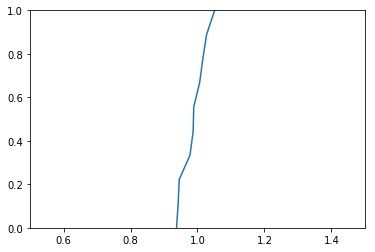

In [13]:
%matplotlib inline
gmap_list = []
var = (gmap1[['distance']].tail(1).iloc[0, 0])
gmap_list.append(var)

var = (gmap2[['distance']].tail(1).iloc[0, 0])
gmap_list.append(var)

var = (gmap3[['distance']].tail(1).iloc[0, 0])
gmap_list.append(var)

var = (gmap4[['distance']].tail(1).iloc[0, 0])
gmap_list.append(var)

var = (gmap5[['distance']].tail(1).iloc[0, 0])
gmap_list.append(var)

var = (gmap6[['distance']].tail(1).iloc[0, 0])
gmap_list.append(var)

var = (gmap7[['distance']].tail(1).iloc[0, 0])
gmap_list.append(var)

var = (gmap8[['distance']].tail(1).iloc[0, 0])
gmap_list.append(var)

var = (gmap9[['distance']].tail(1).iloc[0, 0])
gmap_list.append(var)

var = (gmap10[['distance']].tail(1).iloc[0, 0])
gmap_list.append(var)

gmap_list = gmap_list/(ideal[['distance']].tail(1).iloc[0, 0])

gmap_sorted_data = np.sort(gmap_list)

gmap_yvals=np.arange(len(gmap_sorted_data))/float(len(gmap_sorted_data)-1)

plt.plot(gmap_sorted_data,gmap_yvals)
plt.axis([0.5, 1.5, 0, 1])
plt.show()

# Performing CDF of the position in Gmapping

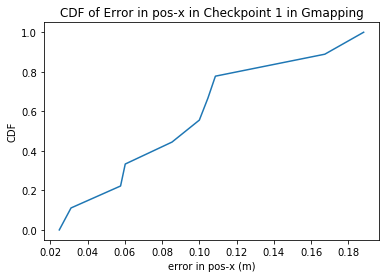

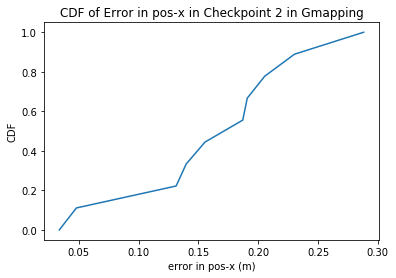

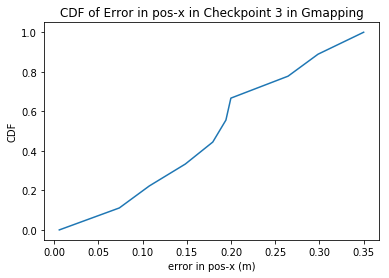

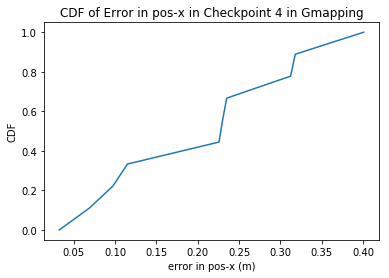

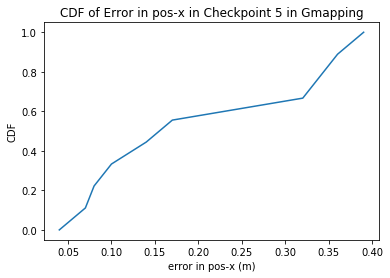

In [14]:
cdf_gmap_points1, cdf_gmap_points2, cdf_gmap_points3, cdf_gmap_points4, cdf_gmap_points5  = table_maker(ideal, gmap1, gmap2, gmap3, gmap4, gmap5, gmap6, gmap7, gmap8, gmap9, gmap10)
#plotting CDF of Error in POS-X Gmapping Check-Point 1
cdf_gmap_points1 = np.sort(cdf_gmap_points1)
cdf_gmap_points1_yvals=np.arange(len(cdf_gmap_points1))/float(len(cdf_gmap_points1)-1)
plt.plot(cdf_gmap_points1,cdf_gmap_points1_yvals)
plt.ylabel("CDF")
plt.xlabel("error in pos-x (m)")
plt.title("CDF of Error in pos-x in Checkpoint 1 in Gmapping")
plt.show()

#plotting CDF of Error in POS-X Gmapping Check-Point 2
cdf_gmap_points2 = np.sort(cdf_gmap_points2)
cdf_gmap_points2_yvals=np.arange(len(cdf_gmap_points2))/float(len(cdf_gmap_points2)-1)
plt.plot(cdf_gmap_points2,cdf_gmap_points2_yvals)
plt.ylabel("CDF")
plt.xlabel("error in pos-x (m)")
plt.title("CDF of Error in pos-x in Checkpoint 2 in Gmapping")
plt.show()

#plotting CDF of Error in POS-X Gmapping Check-Point 3
cdf_gmap_points3 = np.sort(cdf_gmap_points3)
cdf_gmap_points3_yvals=np.arange(len(cdf_gmap_points3))/float(len(cdf_gmap_points3)-1)
plt.plot(cdf_gmap_points3,cdf_gmap_points3_yvals)
plt.ylabel("CDF")
plt.xlabel("error in pos-x (m)")
plt.title("CDF of Error in pos-x in Checkpoint 3 in Gmapping")
plt.show()

#plotting CDF of Error in POS-X Gmapping Check-Point 4
cdf_gmap_points4 = np.sort(cdf_gmap_points4)
cdf_gmap_points4_yvals=np.arange(len(cdf_gmap_points4))/float(len(cdf_gmap_points4)-1)
plt.plot(cdf_gmap_points4,cdf_gmap_points4_yvals)
plt.ylabel("CDF")
plt.xlabel("error in pos-x (m)")
plt.title("CDF of Error in pos-x in Checkpoint 4 in Gmapping")
plt.show()

#plotting CDF of Error in POS-X Gmapping Check-Point 
cdf_gmap_points5 = np.sort(cdf_gmap_points5)
cdf_gmap_points5_yvals=np.arange(len(cdf_gmap_points5))/float(len(cdf_gmap_points5)-1)
plt.plot(cdf_gmap_points5,cdf_gmap_points5_yvals)
plt.ylabel("CDF")
plt.xlabel("error in pos-x (m)")
plt.title("CDF of Error in pos-x in Checkpoint 5 in Gmapping")
plt.show()

# Hector Data

In [15]:
hector1 = pd.read_csv("data/hector/hector_1.csv")
hector1 = preproces(ideal, hector1)
hector1 = all_errors(hector1)

hector2 = pd.read_csv("data/hector/hector_2.csv")
hector2 = preproces(ideal, hector2)
hector2 = all_errors(hector2)

hector3 = pd.read_csv("data/hector/hector_3.csv")
hector3 = preproces(ideal, hector3)
hector3 = all_errors(hector3)

hector4 = pd.read_csv("data/hector/hector_4.csv")
hector4 = preproces(ideal, hector4)
hector4 = all_errors(hector4)

hector5 = pd.read_csv("data/hector/hector_5.csv")
hector5 = preproces(ideal, hector5)
hector5 = all_errors(hector5)

hector6 = pd.read_csv("data/hector/hector_6.csv")
hector6 = preproces(ideal, hector6)
hector6 = all_errors(hector6)

hector7 = pd.read_csv("data/hector/hector_7.csv")
hector7 = preproces(ideal, hector7)
hector7 = all_errors(hector7)

hector8 = pd.read_csv("data/hector/hector_8.csv")
hector8 = preproces(ideal, hector8)
hector8 = all_errors(hector8)

hector9 = pd.read_csv("data/hector/hector_9.csv")
hector9 = preproces(ideal, hector9)
hector9 = all_errors(hector9)

hector10 = pd.read_csv("data/hector/hector_10.csv")
hector10 = preproces(ideal, hector10)
hector10 = all_errors(hector10)


In [16]:
# sample
print("Overview of the processed dataset")
print(hector1.head(3))

Overview of the processed dataset
      pos-x    pos-y     ori-z     ori-w   time  distance  diff-pos-x  \
0  0.000000  0.00000  0.000000  1.000000  205.0      0.00    0.000000   
1  0.005651  0.00014 -0.012343  0.999924  410.0      0.01   -0.008478   
2  0.011304  0.00014 -0.024683  0.999695  615.0      0.02   -0.008488   

   diff-pos-y  diff-ori-z  diff-ori-w  
0    0.000000    0.000000    0.000000  
1   -0.000174    0.006171    0.000057  
2   -0.000523    0.043197    0.000133  


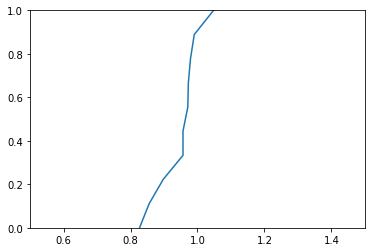

In [17]:
%matplotlib inline
hector_list = []
var = (hector1[['distance']].tail(1).iloc[0, 0])
hector_list.append(var)

var = (hector2[['distance']].tail(1).iloc[0, 0])
hector_list.append(var)

var = (hector3[['distance']].tail(1).iloc[0, 0])
hector_list.append(var)

var = (hector4[['distance']].tail(1).iloc[0, 0])
hector_list.append(var)

var = (hector5[['distance']].tail(1).iloc[0, 0])
hector_list.append(var)

var = (hector6[['distance']].tail(1).iloc[0, 0])
hector_list.append(var)

var = (hector7[['distance']].tail(1).iloc[0, 0])
hector_list.append(var)

var = (hector8[['distance']].tail(1).iloc[0, 0])
hector_list.append(var)

var = (hector9[['distance']].tail(1).iloc[0, 0])
hector_list.append(var)

var = (hector10[['distance']].tail(1).iloc[0, 0])
hector_list.append(var)

hector_list = hector_list/(ideal[['distance']].tail(1).iloc[0, 0])

hector_sorted_data = np.sort(hector_list)

hector_yvals=np.arange(len(hector_sorted_data))/float(len(hector_sorted_data)-1)

plt.plot(hector_sorted_data,hector_yvals)
plt.axis([0.5, 1.5, 0, 1])
plt.show()

# Performing CDF of the position in Hector

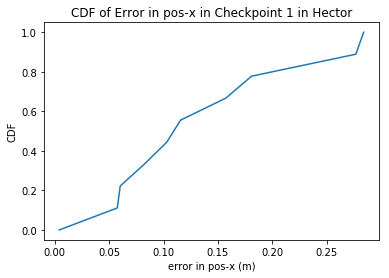

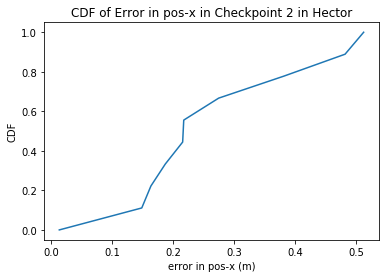

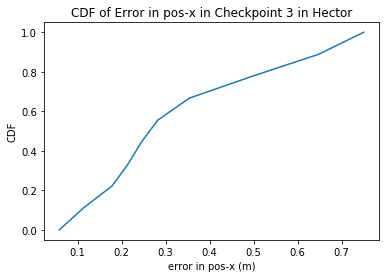

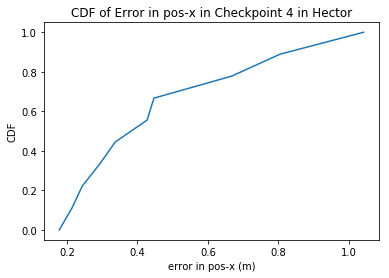

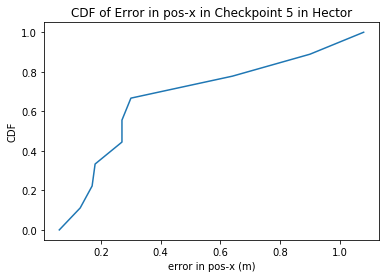

In [18]:
cdf_hector_points1, cdf_hector_points2, cdf_hector_points3, cdf_hector_points4, cdf_hector_points5  = table_maker(ideal, hector1, hector2, hector3, hector4, hector5, hector6, hector7, hector8, hector9, hector10)
#plotting CDF of Error in POS-X Gmapping Check-Point 1
cdf_hector_points1 = np.sort(cdf_hector_points1)
cdf_hector_points1_yvals=np.arange(len(cdf_hector_points1))/float(len(cdf_hector_points1)-1)
plt.plot(cdf_hector_points1,cdf_hector_points1_yvals)
plt.ylabel("CDF")
plt.xlabel("error in pos-x (m)")
plt.title("CDF of Error in pos-x in Checkpoint 1 in Hector")
plt.show()

#plotting CDF of Error in POS-X Hector Check-Point 2
cdf_hector_points2 = np.sort(cdf_hector_points2)
cdf_hector_points2_yvals=np.arange(len(cdf_hector_points2))/float(len(cdf_hector_points2)-1)
plt.plot(cdf_hector_points2,cdf_hector_points2_yvals)
plt.ylabel("CDF")
plt.xlabel("error in pos-x (m)")
plt.title("CDF of Error in pos-x in Checkpoint 2 in Hector")
plt.show()

#plotting CDF of Error in POS-X Hector Check-Point 3
cdf_hector_points3 = np.sort(cdf_hector_points3)
cdf_hector_points3_yvals=np.arange(len(cdf_hector_points3))/float(len(cdf_hector_points3)-1)
plt.plot(cdf_hector_points3,cdf_hector_points3_yvals)
plt.ylabel("CDF")
plt.xlabel("error in pos-x (m)")
plt.title("CDF of Error in pos-x in Checkpoint 3 in Hector")
plt.show()

#plotting CDF of Error in POS-X Hector Check-Point 4
cdf_hector_points4 = np.sort(cdf_hector_points4)
cdf_hector_points4_yvals=np.arange(len(cdf_hector_points4))/float(len(cdf_hector_points4)-1)
plt.plot(cdf_hector_points4,cdf_hector_points4_yvals)
plt.ylabel("CDF")
plt.xlabel("error in pos-x (m)")
plt.title("CDF of Error in pos-x in Checkpoint 4 in Hector")
plt.show()

#plotting CDF of Error in POS-X Hector Check-Point 
cdf_hector_points5 = np.sort(cdf_hector_points5)
cdf_hector_points5_yvals=np.arange(len(cdf_hector_points5))/float(len(cdf_hector_points5)-1)
plt.plot(cdf_hector_points5,cdf_hector_points5_yvals)
plt.ylabel("CDF")
plt.xlabel("error in pos-x (m)")
plt.title("CDF of Error in pos-x in Checkpoint 5 in Hector")
plt.show()

# Plotting cdf of ideal-path vs test-paths of AMCL, Gmapping, Hector

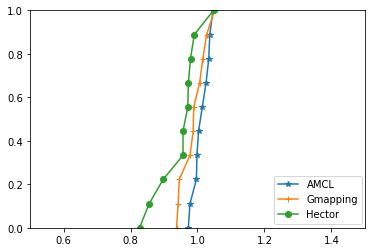

In [19]:
plt.plot(amcl_sorted_data,amcl_yvals, marker='*', label='AMCL')
plt.plot(gmap_sorted_data,gmap_yvals, marker='+', label='Gmapping')
plt.plot(hector_sorted_data,hector_yvals, marker='o', label='Hector')
plt.axis([0.5, 1.5, 0, 1])
plt.legend(bbox_to_anchor=(0.73, 0.24), loc=2, borderaxespad=0.)
#plt.title("CDF of Error in pos-x in Checkpoint 1 of AMCL vs Gma")
plt.savefig("cdf_path.pdf")
plt.show()

# Plotting cdf of error in points of AMCL, Gmapping, Hector

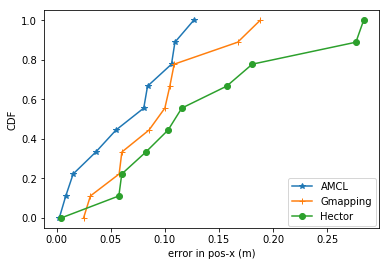

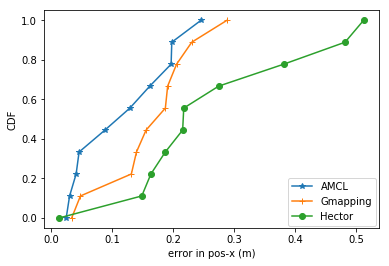

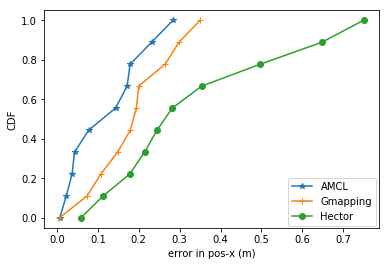

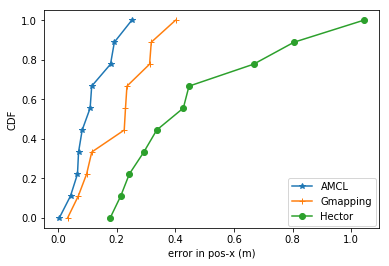

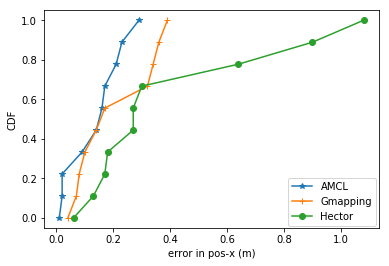

In [20]:
cdf_ideal_points = [0,0,0,0,0]
cdf_ideal_points_yvals=np.arange(len(cdf_ideal_points))/float(len(cdf_ideal_points)-1)

plt.plot(cdf_amcl_points1,cdf_amcl_points1_yvals, marker='*', label='AMCL')
plt.plot(cdf_gmap_points1,cdf_gmap_points1_yvals, marker='+', label='Gmapping')
plt.plot(cdf_hector_points1,cdf_hector_points1_yvals, marker='o', label='Hector')
plt.legend(bbox_to_anchor=(0.73, 0.23), loc=2, borderaxespad=0.)
plt.ylabel("CDF")
plt.xlabel("error in pos-x (m)")
plt.savefig("ch1.pdf")
#plt.title("CDF of Error at pos-x in Checkpoint 1 in AMCL, Gmapping, Hector")
plt.show()

plt.plot(cdf_amcl_points2,cdf_amcl_points2_yvals, marker='*', label='AMCL')
plt.plot(cdf_gmap_points2,cdf_gmap_points2_yvals, marker='+', label='Gmapping')
plt.plot(cdf_hector_points2,cdf_hector_points2_yvals, marker='o', label='Hector')
plt.legend(bbox_to_anchor=(0.73, 0.23), loc=2, borderaxespad=0.)
plt.ylabel("CDF")
plt.xlabel("error in pos-x (m)")
plt.savefig("ch2.pdf")
#plt.title("CDF of Error at pos-x in Checkpoint 2 in AMCL, Gmapping, Hector")
plt.show()

plt.plot(cdf_amcl_points3,cdf_amcl_points3_yvals, marker='*', label='AMCL')
plt.plot(cdf_gmap_points3,cdf_gmap_points3_yvals, marker='+', label='Gmapping')
plt.plot(cdf_hector_points3,cdf_hector_points3_yvals, marker='o', label='Hector')
plt.legend(bbox_to_anchor=(0.73, 0.23), loc=2, borderaxespad=0.)
#plt.title("CDF of Error at pos-x in Checkpoint 3 in AMCL, Gmapping, Hector")
plt.ylabel("CDF")
plt.xlabel("error in pos-x (m)")
plt.savefig("ch3.pdf")
plt.show()

plt.plot(cdf_amcl_points4,cdf_amcl_points4_yvals, marker='*', label='AMCL')
plt.plot(cdf_gmap_points4,cdf_gmap_points4_yvals, marker='+', label='Gmapping')
plt.plot(cdf_hector_points4,cdf_hector_points4_yvals, marker='o', label='Hector')
plt.legend(bbox_to_anchor=(0.73, 0.23), loc=2, borderaxespad=0.)
# plt.title("CDF of Error at pos-x in Checkpoint 4 in AMCL, Gmapping, Hector")
plt.ylabel("CDF")
plt.xlabel("error in pos-x (m)")
plt.savefig("ch4.pdf")
plt.show()

plt.plot(cdf_amcl_points5,cdf_amcl_points5_yvals, marker='*', label='AMCL')
plt.plot(cdf_gmap_points5,cdf_gmap_points5_yvals, marker='+', label='Gmapping')
plt.plot(cdf_hector_points5,cdf_hector_points5_yvals, marker='o', label='Hector')
#plt.title("CDF of Error at pos-x in Checkpoint 5 in AMCL, Gmapping, Hector")
plt.legend(bbox_to_anchor=(0.73, 0.23), loc=2, borderaxespad=0.)
plt.ylabel("CDF")
plt.xlabel("error in pos-x (m)")
plt.savefig("ch5.pdf")
plt.show()

# Using Freedman–Diaconis rule to calculate number of bins

In [21]:
def bin_n_calc(df):
    df_array = df['distance'].values
    q75, q25 = np.percentile(df_array, [75 ,25])
    iqr = q75 - q25
    bin_size  = 2 * (iqr/(len(df_array) ** (1. / 3)))
    final = (max(df_array) - min(df_array))/bin_size
    return final

In [22]:
n_bins = bin_n_calc(ideal) + bin_n_calc(amcl1) + bin_n_calc(amcl2) + bin_n_calc(amcl3) + bin_n_calc(amcl4) + bin_n_calc(amcl5) + bin_n_calc(amcl6) + bin_n_calc(amcl7) + bin_n_calc(amcl8) + bin_n_calc(amcl9) + bin_n_calc(amcl10)
n_bins = n_bins + bin_n_calc(gmap1) + bin_n_calc(gmap2) + bin_n_calc(gmap3) + bin_n_calc(gmap4) + bin_n_calc(gmap5) + bin_n_calc(gmap6) + bin_n_calc(gmap7) + bin_n_calc(gmap8) + bin_n_calc(gmap9) + bin_n_calc(gmap10)
n_bins = n_bins + bin_n_calc(hector1) + bin_n_calc(hector2) + bin_n_calc(hector3) + bin_n_calc(hector4) + bin_n_calc(hector5) + bin_n_calc(hector6) + bin_n_calc(hector7) + bin_n_calc(hector8) + bin_n_calc(hector9) + bin_n_calc(hector10)
n_bins/31

4.4197709914046488

# Average Distance Error Calculation

In [23]:
print("AMCL AVG Distance Error: ", average_error_distance(amcl1, amcl2, amcl3, amcl4, amcl5, amcl6, amcl7, amcl8, amcl9, amcl10, ideal))
print("Gmapping Distance AVG Error: ", average_error_distance(gmap1, gmap2, gmap3, gmap4, gmap5, gmap6, gmap7, gmap8, gmap9, gmap10, ideal))
print("Hector AVG Distance Error: ", average_error_distance(hector1, hector2, hector3, hector4, hector5, hector6, hector7, hector8, hector9, hector10, ideal))

AMCL AVG Distance Error:  0.066
Gmapping Distance AVG Error:  0.075
Hector AVG Distance Error:  0.34


# Boxplots of the Distance Taken by AMCL, Gmapping, Hector and Ideal

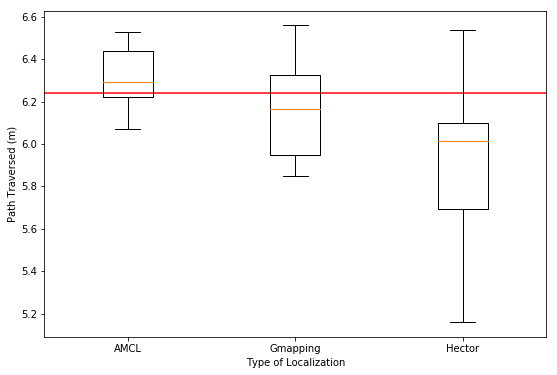

In [24]:
def boxplot_prep(df1, df2, df3, df4, df5, df6, df7, df8, df9, df10):
    box_plot_list = []
    var = (df1[['distance']].tail(1).iloc[0, 0])
    box_plot_list.append(var)

    var = (df2[['distance']].tail(1).iloc[0, 0])
    box_plot_list.append(var)
##df2
    var = (df3[['distance']].tail(1).iloc[0, 0])
    box_plot_list.append(var)

    var = (df4[['distance']].tail(1).iloc[0, 0])
    box_plot_list.append(var)

    var = (df5[['distance']].tail(1).iloc[0, 0])
    box_plot_list.append(var)
##df5
    var = (df6[['distance']].tail(1).iloc[0, 0])
    box_plot_list.append(var)

    var = (df7[['distance']].tail(1).iloc[0, 0])
    box_plot_list.append(var)

    var = (df8[['distance']].tail(1).iloc[0, 0])
    box_plot_list.append(var)

    var = (df9[['distance']].tail(1).iloc[0, 0])
    box_plot_list.append(var)

    var = (df10[['distance']].tail(1).iloc[0, 0])
    box_plot_list.append(var)
    return box_plot_list

amcl_box_plot = boxplot_prep(amcl1, amcl2, amcl3, amcl4, amcl5, amcl6, amcl7, amcl8, amcl9, amcl10)
gmap_box_plot = boxplot_prep(gmap1, gmap2, gmap3, gmap4, gmap5, gmap6, gmap7, gmap8, gmap9, gmap10)
hector_box_plot = boxplot_prep(hector1, hector2, hector3, hector4, hector5, hector6, hector7, hector8, hector9, hector10)
ideal_plot = (ideal[['distance']].tail(1).iloc[0, 0])


    
data_to_plot = [amcl_box_plot, gmap_box_plot, hector_box_plot]
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
plt.axhline(y=ideal_plot, color='r', linestyle='-')
bp = ax.boxplot(data_to_plot)
ax.set_xticklabels(['AMCL', 'Gmapping', 'Hector'])
#plt.title("Box Plot of Paths Traversed by Different Localization Algorithms vs Ideal Path")
plt.xlabel("Type of Localization")
plt.ylabel("Path Traversed (m)")

In [25]:
def quaternion_to_euler_angle(z, w, x=0, y=0):
    ysqr = y * y
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + ysqr)
    X = math.degrees(math.atan2(t0, t1))
    
    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.degrees(math.asin(t2))
    
    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (ysqr + z * z)
    Z = math.degrees(math.atan2(t3, t4))
    
    return Z

In [26]:
def cdf_final_angle(ideal, df, df2, df3, df4, df5, df6, df7, df8, df9, df10):
    oriZ = (ideal[['ori-z']].tail(1).iloc[0, 0])
    oriW = (ideal[['ori-w']].tail(1).iloc[0, 0])
    ideal_ori = quaternion_to_euler_angle(oriZ, oriW)

    list_of_vals = []
    oriZ = (df[['ori-z']].tail(1).iloc[0, 0])
    oriW = (df[['ori-w']].tail(1).iloc[0, 0])
    list_of_vals.append(abs(ideal_ori - (quaternion_to_euler_angle(oriZ, oriW))))
    
    oriZ = (df2[['ori-z']].tail(1).iloc[0, 0])
    oriW = (df2[['ori-w']].tail(1).iloc[0, 0])
    list_of_vals.append(abs(ideal_ori - (quaternion_to_euler_angle(oriZ, oriW))))
    
    oriZ = (df3[['ori-z']].tail(1).iloc[0, 0])
    oriW = (df3[['ori-w']].tail(1).iloc[0, 0])
    list_of_vals.append(abs(ideal_ori - (quaternion_to_euler_angle(oriZ, oriW))))
    
    oriZ = (df4[['ori-z']].tail(1).iloc[0, 0])
    oriW = (df4[['ori-w']].tail(1).iloc[0, 0])
    list_of_vals.append(abs(ideal_ori - (quaternion_to_euler_angle(oriZ, oriW))))
    
    oriZ = (df5[['ori-z']].tail(1).iloc[0, 0])
    oriW = (df5[['ori-w']].tail(1).iloc[0, 0])
    list_of_vals.append(abs(ideal_ori - (quaternion_to_euler_angle(oriZ, oriW))))
    
    oriZ = (df6[['ori-z']].tail(1).iloc[0, 0])
    oriW = (df6[['ori-w']].tail(1).iloc[0, 0])
    list_of_vals.append(abs(ideal_ori - (quaternion_to_euler_angle(oriZ, oriW))))
    
    oriZ = (df7[['ori-z']].tail(1).iloc[0, 0])
    oriW = (df7[['ori-w']].tail(1).iloc[0, 0])
    list_of_vals.append(abs(ideal_ori - (quaternion_to_euler_angle(oriZ, oriW))))
    
    oriZ = (df8[['ori-z']].tail(1).iloc[0, 0])
    oriW = (df8[['ori-w']].tail(1).iloc[0, 0])
    list_of_vals.append(abs(ideal_ori - (quaternion_to_euler_angle(oriZ, oriW))))
    
    oriZ = (df9[['ori-z']].tail(1).iloc[0, 0])
    oriW = (df9[['ori-w']].tail(1).iloc[0, 0])
    list_of_vals.append(abs(ideal_ori - (quaternion_to_euler_angle(oriZ, oriW))))
    
    oriZ = (df10[['ori-z']].tail(1).iloc[0, 0])
    oriW = (df10[['ori-w']].tail(1).iloc[0, 0])
    list_of_vals.append(abs(ideal_ori - (quaternion_to_euler_angle(oriZ, oriW))))
    
    return list_of_vals

In [27]:
amcl_final_angle_error = cdf_final_angle(ideal, amcl1, amcl2, amcl3, amcl4, amcl5, amcl6, amcl7, amcl8, amcl9, amcl10)
gmap_final_angle_error = cdf_final_angle(ideal, gmap1, gmap2, gmap3, gmap4, gmap5, gmap6, gmap7, gmap8, gmap9, gmap10)
hector_final_angle_error = cdf_final_angle(ideal, hector1, hector2, hector3, hector4, hector5, hector6, hector7, hector8, hector9, hector10)

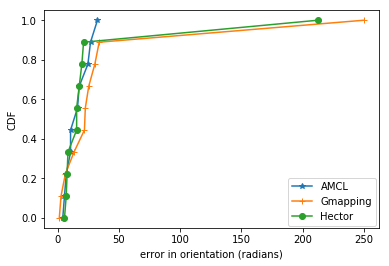

In [28]:
amcl_final_angle_error = np.sort(amcl_final_angle_error)
gmap_final_angle_error = np.sort(gmap_final_angle_error)
hector_final_angle_error = np.sort(hector_final_angle_error)

amcl_final_angle_error_yvals=np.arange(len(amcl_final_angle_error))/float(len(amcl_final_angle_error)-1)
gmap_final_angle_error_yvals=np.arange(len(gmap_final_angle_error))/float(len(gmap_final_angle_error)-1)
hector_final_angle_error_yvals=np.arange(len(hector_final_angle_error))/float(len(hector_final_angle_error)-1)

plt.plot(amcl_final_angle_error,amcl_final_angle_error_yvals, marker="*", label='AMCL')
plt.plot(gmap_final_angle_error,gmap_final_angle_error_yvals, marker="+", label='Gmapping')
plt.plot(hector_final_angle_error,hector_final_angle_error_yvals, marker="o", label='Hector')
#plt.title("CDF of Error at orientation in final destination in AMCL, Gmapping, Hector")
plt.legend(bbox_to_anchor=(0.73, 0.23), loc=2, borderaxespad=0.)
plt.ylabel("CDF")
plt.xlabel("error in orientation (radians)")
plt.savefig("cdf_ori.pdf")
plt.show()

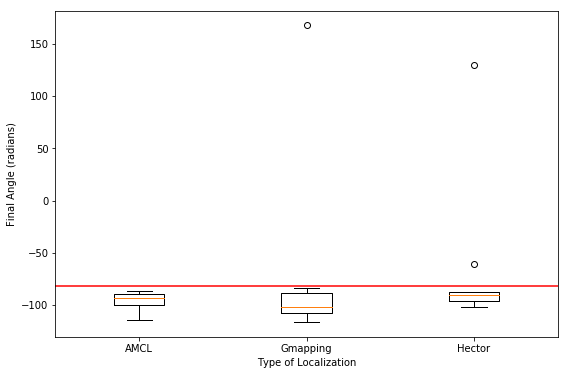

In [29]:
def boxplot_orientation_prep(df1, df2, df3, df4, df5, df6, df7, df8, df9, df10):
    box_plot_list = []
    var = quaternion_to_euler_angle((df1[['ori-z']].tail(1).iloc[0, 0]), (df1[['ori-w']].tail(1).iloc[0, 0]))
    
    var = quaternion_to_euler_angle((df2[['ori-z']].tail(1).iloc[0, 0]), (df2[['ori-w']].tail(1).iloc[0, 0]))
    box_plot_list.append(var)

    var = quaternion_to_euler_angle((df3[['ori-z']].tail(1).iloc[0, 0]), (df3[['ori-w']].tail(1).iloc[0, 0]))
    box_plot_list.append(var)

    var = quaternion_to_euler_angle((df4[['ori-z']].tail(1).iloc[0, 0]), (df4[['ori-w']].tail(1).iloc[0, 0]))
    box_plot_list.append(var)

    var = quaternion_to_euler_angle((df5[['ori-z']].tail(1).iloc[0, 0]), (df5[['ori-w']].tail(1).iloc[0, 0]))
    box_plot_list.append(var)

    var = quaternion_to_euler_angle((df6[['ori-z']].tail(1).iloc[0, 0]), (df6[['ori-w']].tail(1).iloc[0, 0]))
    box_plot_list.append(var)

    var = quaternion_to_euler_angle((df7[['ori-z']].tail(1).iloc[0, 0]), (df7[['ori-w']].tail(1).iloc[0, 0]))
    box_plot_list.append(var)

    var = quaternion_to_euler_angle((df8[['ori-z']].tail(1).iloc[0, 0]), (df8[['ori-w']].tail(1).iloc[0, 0]))
    box_plot_list.append(var)

    var = quaternion_to_euler_angle((df9[['ori-z']].tail(1).iloc[0, 0]), (df9[['ori-w']].tail(1).iloc[0, 0]))
    box_plot_list.append(var)

    var = quaternion_to_euler_angle((df10[['ori-z']].tail(1).iloc[0, 0]), (df1[['ori-w']].tail(1).iloc[0, 0]))
    box_plot_list.append(var)
    
    return box_plot_list

amcl_box_plot = boxplot_orientation_prep(amcl1, amcl2, amcl3, amcl4, amcl5, amcl6, amcl7, amcl8, amcl9, amcl10)
gmap_box_plot = boxplot_orientation_prep(gmap1, gmap2, gmap3, gmap4, gmap5, gmap6, gmap7, gmap8, gmap9, gmap10)
hector_box_plot = boxplot_orientation_prep(hector1, hector2, hector3, hector4, hector5, hector6, hector7, hector8, hector9, hector10)

oriZ = (ideal[['ori-z']].tail(1).iloc[0, 0])
oriW = (ideal[['ori-w']].tail(1).iloc[0, 0])
ideal_plot = quaternion_to_euler_angle(oriZ, oriW)

data_to_plot = [amcl_box_plot, gmap_box_plot, hector_box_plot]
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
plt.axhline(y=ideal_plot, color='r', linestyle='-')
bp = ax.boxplot(data_to_plot)
ax.set_xticklabels(['AMCL', 'Gmapping', 'Hector'])
#plt.title("Box Plot of Paths Traversed by Different Localization Algorithms vs Ideal Path")
plt.xlabel("Type of Localization")
plt.ylabel("Final Angle (radians)")

# Mean Absolute Error

In [38]:
def acc_the_index_to_check(df, col):
    n_bins = 5
    vars_list = []
    end = df[[col]].tail(1).iloc[0, 0]
    end = round(end,2)
    start = round((end/n_bins),2)
    var = start
    for i in range(0, n_bins-1):
        new = acc_check_the_val(df, var, col)
        var = var + start
        vars_list.append(new)
    vars_list.append(end)
    return vars_list


def acc_check_the_val(df, distance_index, col):
    var = 0
    distance_index = round(distance_index, 2)
    for i in range(0, len(df)):
        if((df['distance'].iloc[i] > distance_index-0.05) and (df['distance'].iloc[i] < distance_index+0.05)):
            var = df[col].iloc[i]
            pass
    return var
#var = quaternion_to_euler_angle((df1[['ori-z']].tail(1).iloc[0, 0]), (df1[['ori-w']].tail(1).iloc[0, 0]))

def acc_the_index_to_check_angle(df):
    n_bins = 30
    vars_list = []
    new_list = []
    end = quaternion_to_euler_angle((df[['ori-z']].tail(1).iloc[0,0]), (df[['ori-w']].tail(1).iloc[0,0]))
    start = round((end/n_bins),1)
    var = start
    for i in range(1, n_bins-1):
        new = acc_check_the_val_angle(df, var)
        var = var + start
        vars_list.append(new)
    new = acc_check_the_val_angle(df, (end-0.05))
    vars_list.append(new)
    return vars_list

def acc_check_the_val_angle(df, distance_index):
    var = 0
    distance_index = round(distance_index, 2)
    for i in range(0, len(df)):
        if((df['distance'].iloc[i] > distance_index-0.05) and (df['distance'].iloc[i] < distance_index+0.05)):
            var = quaternion_to_euler_angle((df['ori-z'].iloc[i]), (df['ori-w'][i]))
            pass
    return var

def error_table_maker(col, ideal, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10):
    cdf_list_ideal = acc_the_index_to_check(ideal, col)
    cdf_list_1 = acc_the_index_to_check(df1, col)
    cdf_list_2 = acc_the_index_to_check(df2, col)
    cdf_list_3 = acc_the_index_to_check(df3, col)
    cdf_list_4 = acc_the_index_to_check(df4, col)
    cdf_list_5 = acc_the_index_to_check(df5, col)
    cdf_list_6 = acc_the_index_to_check(df6, col)
    cdf_list_7 = acc_the_index_to_check(df7, col)
    cdf_list_8 = acc_the_index_to_check(df8, col)
    cdf_list_9 = acc_the_index_to_check(df9, col)
    cdf_list_10 = acc_the_index_to_check(df10, col)
    
    final_list_1 = []
    final_list_2 = []
    final_list_3 = []
    final_list_4 = []
    final_list_5 = []
    
    final_list_1.append(cdf_list_1[0])
    final_list_1.append(cdf_list_2[0])
    final_list_1.append(cdf_list_3[0])
    final_list_1.append(cdf_list_4[0])
    final_list_1.append(cdf_list_5[0])
    final_list_1.append(cdf_list_6[0])
    final_list_1.append(cdf_list_7[0])
    final_list_1.append(cdf_list_8[0])
    final_list_1.append(cdf_list_9[0])
    final_list_1.append(cdf_list_10[0])
    
    final_list_2.append(cdf_list_1[1])
    final_list_2.append(cdf_list_2[1])
    final_list_2.append(cdf_list_3[1])
    final_list_2.append(cdf_list_4[1])
    final_list_2.append(cdf_list_5[1])
    final_list_2.append(cdf_list_6[1])
    final_list_2.append(cdf_list_7[1])
    final_list_2.append(cdf_list_8[1])
    final_list_2.append(cdf_list_9[1])
    final_list_2.append(cdf_list_10[1])
    
    final_list_3.append(cdf_list_1[2])
    final_list_3.append(cdf_list_2[2])
    final_list_3.append(cdf_list_3[2])
    final_list_3.append(cdf_list_4[2])
    final_list_3.append(cdf_list_5[2])
    final_list_3.append(cdf_list_6[2])
    final_list_3.append(cdf_list_7[2])
    final_list_3.append(cdf_list_8[2])
    final_list_3.append(cdf_list_9[2])
    final_list_3.append(cdf_list_10[2])
    
    final_list_4.append(cdf_list_1[3])
    final_list_4.append(cdf_list_2[3])
    final_list_4.append(cdf_list_3[3])
    final_list_4.append(cdf_list_4[3])
    final_list_4.append(cdf_list_5[3])
    final_list_4.append(cdf_list_6[3])
    final_list_4.append(cdf_list_7[3])
    final_list_4.append(cdf_list_8[3])
    final_list_4.append(cdf_list_9[3])
    final_list_4.append(cdf_list_10[3])
    
    final_list_5.append(cdf_list_1[4])
    final_list_5.append(cdf_list_2[4])
    final_list_5.append(cdf_list_3[4])
    final_list_5.append(cdf_list_4[4])
    final_list_5.append(cdf_list_5[4])
    final_list_5.append(cdf_list_6[4])
    final_list_5.append(cdf_list_7[4])
    final_list_5.append(cdf_list_8[4])
    final_list_5.append(cdf_list_9[4])
    final_list_5.append(cdf_list_10[4])
    
    return final_list_1, final_list_2, final_list_3, final_list_4, final_list_5, cdf_list_ideal



In [39]:
amcl_acc_pos_x_list, amcl_acc_pos_x_list_2, amcl_acc_pos_x_list_3, amcl_acc_pos_x_list_4, amcl_acc_pos_x_list_5, ideal_list  = error_table_maker('pos-x', ideal, amcl1, amcl2, amcl3, amcl4, amcl5, amcl6, amcl7, amcl8, amcl9, amcl10)
var = mean_absolute_error(ideal_list, acc_the_index_to_check(amcl1, 'pos-x'))
var = var + mean_absolute_error(ideal_list, acc_the_index_to_check(amcl2, 'pos-x'))
var = var + mean_absolute_error(ideal_list, acc_the_index_to_check(amcl3, 'pos-x'))
var = var + mean_absolute_error(ideal_list, acc_the_index_to_check(amcl4, 'pos-x'))
var = var + mean_absolute_error(ideal_list, acc_the_index_to_check(amcl5, 'pos-x'))
var = var + mean_absolute_error(ideal_list, acc_the_index_to_check(amcl6, 'pos-x'))
var = var + mean_absolute_error(ideal_list, acc_the_index_to_check(amcl7, 'pos-x'))
var = var + mean_absolute_error(ideal_list, acc_the_index_to_check(amcl8, 'pos-x'))
var = var + mean_absolute_error(ideal_list, acc_the_index_to_check(amcl9, 'pos-x'))
var = var + mean_absolute_error(ideal_list, acc_the_index_to_check(amcl10, 'pos-x'))

print('AMCL')
final_x = var/10
print(final_x)

var_y = mean_absolute_error(ideal_list, acc_the_index_to_check(amcl1, 'pos-y'))
var_y = var_y + mean_absolute_error(ideal_list, acc_the_index_to_check(amcl2, 'pos-y'))
var_y = var_y + mean_absolute_error(ideal_list, acc_the_index_to_check(amcl3, 'pos-y'))
var_y = var_y + mean_absolute_error(ideal_list, acc_the_index_to_check(amcl4, 'pos-y'))
var_y = var_y + mean_absolute_error(ideal_list, acc_the_index_to_check(amcl5, 'pos-y'))
var_y = var_y + mean_absolute_error(ideal_list, acc_the_index_to_check(amcl6, 'pos-y'))
var_y = var_y + mean_absolute_error(ideal_list, acc_the_index_to_check(amcl7, 'pos-y'))
var_y = var_y + mean_absolute_error(ideal_list, acc_the_index_to_check(amcl8, 'pos-y'))
var_y = var_y + mean_absolute_error(ideal_list, acc_the_index_to_check(amcl9, 'pos-y'))
var_y = var_y + mean_absolute_error(ideal_list, acc_the_index_to_check(amcl10, 'pos-y'))

final_y = var_y/10
print(final_y)

var_z = mean_absolute_error(ideal_list, acc_the_index_to_check(amcl1, 'ori-z'))
var_z = var_z + mean_absolute_error(ideal_list, acc_the_index_to_check(amcl2, 'ori-z'))
var_z = var_z + mean_absolute_error(ideal_list, acc_the_index_to_check(amcl3, 'ori-z'))
var_z = var_z + mean_absolute_error(ideal_list, acc_the_index_to_check(amcl4, 'ori-z'))
var_z = var_z + mean_absolute_error(ideal_list, acc_the_index_to_check(amcl5, 'ori-z'))
var_z = var_z + mean_absolute_error(ideal_list, acc_the_index_to_check(amcl6, 'ori-z'))
var_z = var_z + mean_absolute_error(ideal_list, acc_the_index_to_check(amcl7, 'ori-z'))
var_z = var_z + mean_absolute_error(ideal_list, acc_the_index_to_check(amcl8, 'ori-z'))
var_z = var_z + mean_absolute_error(ideal_list, acc_the_index_to_check(amcl9, 'ori-z'))
var_z = var_z + mean_absolute_error(ideal_list, acc_the_index_to_check(amcl10, 'ori-z'))

final_z = var_z/10
print(final_z)

var_w = mean_absolute_error(ideal_list, acc_the_index_to_check(amcl1, 'ori-w'))
var_w = var_w + mean_absolute_error(ideal_list, acc_the_index_to_check(amcl2, 'ori-w'))
var_w = var_w + mean_absolute_error(ideal_list, acc_the_index_to_check(amcl3, 'ori-w'))
var_w = var_w + mean_absolute_error(ideal_list, acc_the_index_to_check(amcl4, 'ori-w'))
var_w = var_w + mean_absolute_error(ideal_list, acc_the_index_to_check(amcl5, 'ori-w'))
var_w = var_w + mean_absolute_error(ideal_list, acc_the_index_to_check(amcl6, 'ori-w'))
var_w = var_w + mean_absolute_error(ideal_list, acc_the_index_to_check(amcl7, 'ori-w'))
var_w = var_w + mean_absolute_error(ideal_list, acc_the_index_to_check(amcl8, 'ori-w'))
var_w = var_w + mean_absolute_error(ideal_list, acc_the_index_to_check(amcl9, 'ori-w'))
var_w = var_w + mean_absolute_error(ideal_list, acc_the_index_to_check(amcl10, 'ori-w'))

final_w = var_w/10
print(final_w)

AMCL
0.176535471647
3.49319641409
3.31359641409
2.24109881736


In [40]:
var = mean_absolute_error(ideal_list, acc_the_index_to_check(gmap1, 'pos-x'))
var = var + mean_absolute_error(ideal_list, acc_the_index_to_check(gmap2, 'pos-x'))
var = var + mean_absolute_error(ideal_list, acc_the_index_to_check(gmap3, 'pos-x'))
var = var + mean_absolute_error(ideal_list, acc_the_index_to_check(gmap4, 'pos-x'))
var = var + mean_absolute_error(ideal_list, acc_the_index_to_check(gmap5, 'pos-x'))
var = var + mean_absolute_error(ideal_list, acc_the_index_to_check(gmap6, 'pos-x'))
var = var + mean_absolute_error(ideal_list, acc_the_index_to_check(gmap7, 'pos-x'))
var = var + mean_absolute_error(ideal_list, acc_the_index_to_check(gmap8, 'pos-x'))
var = var + mean_absolute_error(ideal_list, acc_the_index_to_check(gmap9, 'pos-x'))
var = var + mean_absolute_error(ideal_list, acc_the_index_to_check(gmap10, 'pos-x'))
print('Gmapping')
final_x = var/10
print(final_x)

var_y = mean_absolute_error(ideal_list, acc_the_index_to_check(gmap1, 'pos-y'))
var_y = var_y + mean_absolute_error(ideal_list, acc_the_index_to_check(gmap2, 'pos-y'))
var_y = var_y + mean_absolute_error(ideal_list, acc_the_index_to_check(gmap3, 'pos-y'))
var_y = var_y + mean_absolute_error(ideal_list, acc_the_index_to_check(gmap4, 'pos-y'))
var_y = var_y + mean_absolute_error(ideal_list, acc_the_index_to_check(gmap5, 'pos-y'))
var_y = var_y + mean_absolute_error(ideal_list, acc_the_index_to_check(gmap6, 'pos-y'))
var_y = var_y + mean_absolute_error(ideal_list, acc_the_index_to_check(gmap7, 'pos-y'))
var_y = var_y + mean_absolute_error(ideal_list, acc_the_index_to_check(gmap8, 'pos-y'))
var_y = var_y + mean_absolute_error(ideal_list, acc_the_index_to_check(gmap9, 'pos-y'))
var_y = var_y + mean_absolute_error(ideal_list, acc_the_index_to_check(gmap10, 'pos-y'))

final_y = var_y/10
print(final_y)

var_z = mean_absolute_error(ideal_list, acc_the_index_to_check(gmap1, 'ori-z'))
var_z = var_z + mean_absolute_error(ideal_list, acc_the_index_to_check(gmap2, 'ori-z'))
var_z = var_z + mean_absolute_error(ideal_list, acc_the_index_to_check(gmap3, 'ori-z'))
var_z = var_z + mean_absolute_error(ideal_list, acc_the_index_to_check(gmap4, 'ori-z'))
var_z = var_z + mean_absolute_error(ideal_list, acc_the_index_to_check(gmap5, 'ori-z'))
var_z = var_z + mean_absolute_error(ideal_list, acc_the_index_to_check(gmap6, 'ori-z'))
var_z = var_z + mean_absolute_error(ideal_list, acc_the_index_to_check(gmap7, 'ori-z'))
var_z = var_z + mean_absolute_error(ideal_list, acc_the_index_to_check(gmap8, 'ori-z'))
var_z = var_z + mean_absolute_error(ideal_list, acc_the_index_to_check(gmap9, 'ori-z'))
var_z = var_z + mean_absolute_error(ideal_list, acc_the_index_to_check(gmap10, 'ori-z'))

final_z = var_z/10
print(final_z)

var_w = mean_absolute_error(ideal_list, acc_the_index_to_check(gmap1, 'ori-w'))
var_w = var_w + mean_absolute_error(ideal_list, acc_the_index_to_check(gmap2, 'ori-w'))
var_w = var_w + mean_absolute_error(ideal_list, acc_the_index_to_check(gmap3, 'ori-w'))
var_w = var_w + mean_absolute_error(ideal_list, acc_the_index_to_check(gmap4, 'ori-w'))
var_w = var_w + mean_absolute_error(ideal_list, acc_the_index_to_check(gmap5, 'ori-w'))
var_w = var_w + mean_absolute_error(ideal_list, acc_the_index_to_check(gmap6, 'ori-w'))
var_w = var_w + mean_absolute_error(ideal_list, acc_the_index_to_check(gmap7, 'ori-w'))
var_w = var_w + mean_absolute_error(ideal_list, acc_the_index_to_check(gmap8, 'ori-w'))
var_w = var_w + mean_absolute_error(ideal_list, acc_the_index_to_check(gmap9, 'ori-w'))
var_w = var_w + mean_absolute_error(ideal_list, acc_the_index_to_check(gmap10, 'ori-w'))

final_w = var_w/10
print(final_w)

Gmapping
0.256962635971
3.48119641409
3.32079641409
2.29509253036


In [41]:
var = mean_absolute_error(ideal_list, acc_the_index_to_check(hector1, 'pos-x'))
var = var + mean_absolute_error(ideal_list, acc_the_index_to_check(hector2, 'pos-x'))
var = var + mean_absolute_error(ideal_list, acc_the_index_to_check(hector3, 'pos-x'))
var = var + mean_absolute_error(ideal_list, acc_the_index_to_check(hector4, 'pos-x'))
var = var + mean_absolute_error(ideal_list, acc_the_index_to_check(hector5, 'pos-x'))
var = var + mean_absolute_error(ideal_list, acc_the_index_to_check(hector6, 'pos-x'))
var = var + mean_absolute_error(ideal_list, acc_the_index_to_check(hector7, 'pos-x'))
var = var + mean_absolute_error(ideal_list, acc_the_index_to_check(hector8, 'pos-x'))
var = var + mean_absolute_error(ideal_list, acc_the_index_to_check(hector9, 'pos-x'))
var = var + mean_absolute_error(ideal_list, acc_the_index_to_check(hector10, 'pos-x'))

print('Hector')
final_x = var/10
print(final_x)

var_y = mean_absolute_error(ideal_list, acc_the_index_to_check(hector1, 'pos-y'))
var_y = var_y + mean_absolute_error(ideal_list, acc_the_index_to_check(hector2, 'pos-y'))
var_y = var_y + mean_absolute_error(ideal_list, acc_the_index_to_check(hector3, 'pos-y'))
var_y = var_y + mean_absolute_error(ideal_list, acc_the_index_to_check(hector4, 'pos-y'))
var_y = var_y + mean_absolute_error(ideal_list, acc_the_index_to_check(hector5, 'pos-y'))
var_y = var_y + mean_absolute_error(ideal_list, acc_the_index_to_check(hector6, 'pos-y'))
var_y = var_y + mean_absolute_error(ideal_list, acc_the_index_to_check(hector7, 'pos-y'))
var_y = var_y + mean_absolute_error(ideal_list, acc_the_index_to_check(hector8, 'pos-y'))
var_y = var_y + mean_absolute_error(ideal_list, acc_the_index_to_check(hector9, 'pos-y'))
var_y = var_y + mean_absolute_error(ideal_list, acc_the_index_to_check(hector10, 'pos-y'))

final_y = var_y/10
print(final_y)

var_z = mean_absolute_error(ideal_list, acc_the_index_to_check(hector1, 'ori-z'))
var_z = var_z + mean_absolute_error(ideal_list, acc_the_index_to_check(hector2, 'ori-z'))
var_z = var_z + mean_absolute_error(ideal_list, acc_the_index_to_check(hector3, 'ori-z'))
var_z = var_z + mean_absolute_error(ideal_list, acc_the_index_to_check(hector4, 'ori-z'))
var_z = var_z + mean_absolute_error(ideal_list, acc_the_index_to_check(hector5, 'ori-z'))
var_z = var_z + mean_absolute_error(ideal_list, acc_the_index_to_check(hector6, 'ori-z'))
var_z = var_z + mean_absolute_error(ideal_list, acc_the_index_to_check(hector7, 'ori-z'))
var_z = var_z + mean_absolute_error(ideal_list, acc_the_index_to_check(hector8, 'ori-z'))
var_z = var_z + mean_absolute_error(ideal_list, acc_the_index_to_check(hector9, 'ori-z'))
var_z = var_z + mean_absolute_error(ideal_list, acc_the_index_to_check(hector10, 'ori-z'))

final_z = var_z/10
print(final_z)

var_w = mean_absolute_error(ideal_list, acc_the_index_to_check(hector1, 'ori-w'))
var_w = var_w + mean_absolute_error(ideal_list, acc_the_index_to_check(hector2, 'ori-w'))
var_w = var_w + mean_absolute_error(ideal_list, acc_the_index_to_check(hector3, 'ori-w'))
var_w = var_w + mean_absolute_error(ideal_list, acc_the_index_to_check(hector4, 'ori-w'))
var_w = var_w + mean_absolute_error(ideal_list, acc_the_index_to_check(hector5, 'ori-w'))
var_w = var_w + mean_absolute_error(ideal_list, acc_the_index_to_check(hector6, 'ori-w'))
var_w = var_w + mean_absolute_error(ideal_list, acc_the_index_to_check(hector7, 'ori-w'))
var_w = var_w + mean_absolute_error(ideal_list, acc_the_index_to_check(hector8, 'ori-w'))
var_w = var_w + mean_absolute_error(ideal_list, acc_the_index_to_check(hector9, 'ori-w'))
var_w = var_w + mean_absolute_error(ideal_list, acc_the_index_to_check(hector10, 'ori-w'))

final_w = var_w/10
print(final_w)

Hector
0.511992994846
3.46359641409
3.30539641409
2.32670598009


| Localization | MAE pos-x      | MAE pos-y     | MAE ori-z     | MAE ori-w     |
| ------------ | -------------- | ------------- | ------------- | ------------- |
| AMCL         | 0.176535471647 | 3.49319641409 | 3.31359641409 | 2.24109881736 |
| Gmapping     | 0.256962635971 | 3.48119641409 | 3.32079641409 | 2.29509253036 |
| Hector       | 0.511992994846 | 3.46359641409 | 3.30539641409 | 2.32670598009 |
